# Detecting Malaria In Red Blood Cells Using CNN and TensorFlow and Keras

  This project aims to utilize a convolutional neural network to identify malaria from blood cells images. The dataset was taken from the original NIH website: https://lhncbc.nlm.nih.gov/publication/pub9932. 
  

For more information, please contact: washieu05@gmail.com 

### Importing Essential Libraries

In [1]:
import os 
import warnings
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D

from sklearn.metrics import classification_report, confusion_matrix

### Loading and Visualizing the Data

In [2]:
data_dir = 'C:/Users/washi/Desktop/TF_2_Notebooks_and_Data/04-CNNs/cell_images/'
os.listdir(data_dir)

['test', 'train']

In [3]:
test_path = data_dir +'test/'
train_path = data_dir + 'train/'

print(os.listdir(test_path))
print(os.listdir(train_path))

['parasitized', 'uninfected']
['parasitized', 'uninfected']


In [4]:
print(os.listdir(train_path+'parasitized')[0])
print(os.listdir(train_path+'uninfected')[0])

C100P61ThinF_IMG_20150918_144104_cell_162.png
C100P61ThinF_IMG_20150918_144104_cell_128.png


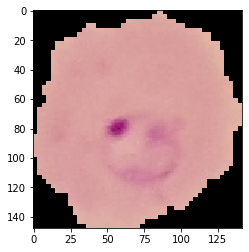

In [5]:
para_cell = 'cell_images/train/parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'
plt.imshow(imread(para_cell))

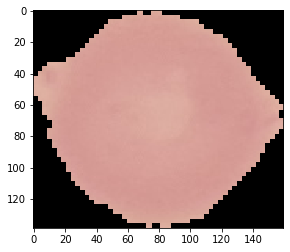

In [6]:
uninfected_cell = 'cell_images/train/uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png'
plt.imshow(imread(uninfected_cell))

Now that we've officially loaded the image and have confirmed that we have both cells that have been parasitized and uninfected, we can move on to data preprocessing. 

In [7]:
#Checking the total amount of images that we have for both the cells that have a parasite and the ones that do not . 
print(len(os.listdir(train_path+'uninfected')))
print(len(os.listdir(train_path+'parasitized')))

12480
12480


Now, let's explore the average dimensions of these images and find a common ground. 

In [8]:
para_img = imread(para_cell)
uninfected_img = imread(uninfected_cell)

print(para_img.shape)
print(uninfected_img.shape)

(148, 142, 3)
(139, 160, 3)


In [9]:
dim1 = []
dim2 = []

for image_filename in os.listdir(test_path+'uninfected'):
    img = imread(test_path+'uninfected/'+image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

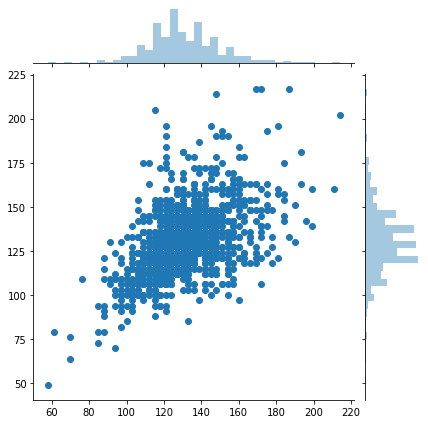

In [10]:
#Visualizing the dimensions
sns.jointplot(dim1, dim2)

We can clearly indicate that there seems to be an average image dimension of around 130. Let's explore that with numpy.mean()

In [11]:
print(np.mean(dim1))
print(np.mean(dim2))

130.92538461538462
130.75


As we can see, our estimate was correct. Let's reshape our images to (130, 130, 3). 

In [12]:
image_shape = (130, 130, 3)

### Preparing the Data for the Model

Because of the high number of images that we have in this dataset, we can utilize some pre-built functions in Keras to process the data for us. This will help us generate batches from a directory and allow us to quickly manipulate the images.Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the ImageDataGenerator to do this automatically for us. 

In [13]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

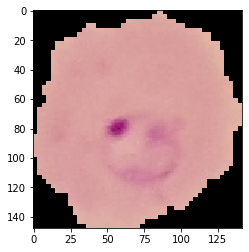

In [14]:
plt.imshow(para_img)

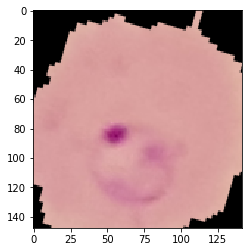

In [15]:
plt.imshow(image_gen.random_transform(para_img))

   As we can see, the image named <code>para_img </code>has now been transformed by using <code>ImageDataGenerator</code>. This helps our model become more robust when being tasked to detect malaria in images that it has never seen before. 
   
   ### Generating Many Manipulated Images From A Directory
   
   In order to use <code>.flow_from_directory</code>, you must organize the images in sub-directories. This directories should only contain images of one class, thereby meaning that we need one folder per class of images. 

In [16]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [17]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


### Generating the Model

In [18]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [20]:
#Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

### Training the Model

In [21]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [22]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [23]:

results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 363s 233ms/step - loss: 0.5656 - accuracy: 0.6899 - val_loss: 0.5090 - val_accuracy: 0.7846
Epoch 2/20
1560/1560 [==============================] - 359s 230ms/step - loss: 0.2486 - accuracy: 0.9203 - val_loss: 0.1955 - val_accuracy: 0.9354
Epoch 3/20
1560/1560 [==============================] - 361s 231ms/step - loss: 0.1843 - accuracy: 0.9427 - val_loss: 0.1630 - val_accuracy: 0.9465
Epoch 4/20
1560/1560 [==============================] - 361s 231ms/step - loss: 0.1700 - accuracy: 0.9462 - val_loss: 0.1713 - val_accuracy: 0.9465
Epoch 5/20
1560/1560 [==============================] - 359s 230ms/step - loss: 0.1639 - accuracy: 0.9488 - val_loss: 0.1689 - val_accuracy: 0.9492


### Evaluating the Model

In [24]:
losses = pd.DataFrame(model.history.history)

In [25]:
losses

,loss,accuracy,val_loss,val_accuracy
0,0.565595,0.689879,0.509004,0.784615
1,0.248629,0.920346,0.195485,0.935385
2,0.184358,0.942664,0.162962,0.946538
3,0.170000,0.946230,0.171304,0.946538
4,0.163929,0.948754,0.168915,0.949231


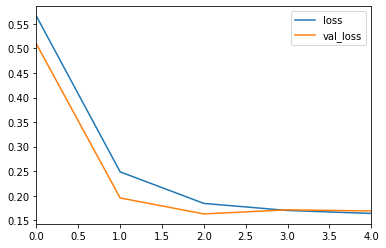

In [26]:
losses[['loss', 'val_loss']].plot()

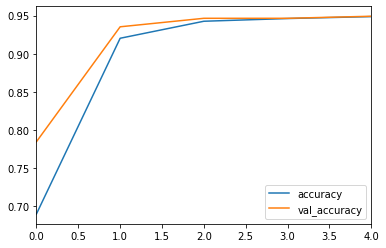

In [27]:
losses[['accuracy', 'val_accuracy']].plot()

In [28]:
model.evaluate_generator(test_image_gen)

[0.16696931784358332, 0.94576925]

In [29]:
pred_probs = model.predict_generator(test_image_gen)
pred_probs

array([[7.4833632e-05],
       [2.1928549e-04],
       [4.7442317e-04],
       ...,
       [9.4040561e-01],
       [9.6954465e-01],
       [9.6665144e-01]], dtype=float32)

In [31]:
predictions = pred_probs > 0.5
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1300
           1       0.94      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [32]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1215,   85],
       [  56, 1244]], dtype=int64)

### Predicting on an Image

In [34]:
my_image = image.load_img(para_cell, target_size=image_shape)

In [35]:
my_image = image.img_to_array(my_image)

In [36]:
my_image = np.expand_dims(my_image, axis = 0)

In [37]:
model.predict(my_image)

array([[0.]], dtype=float32)

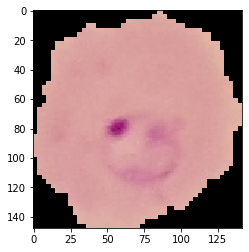

In [40]:
plt.imshow(para_img)

In [43]:
print(train_image_gen.class_indices)
print(test_image_gen.class_indices)

{'parasitized': 0, 'uninfected': 1}
{'parasitized': 0, 'uninfected': 1}


As we can see, our model was able to correctly predict whether the blood cell had malaria. The image that we had provided was a cell that had been infected by malaria and the model indicated that by reporting that the image can be classified as <code>0</code>. As we can see from the <code>class_indicies</code>, <code>0</code> was the class that contained parasitic cells. 

Our model also maintained almost a 95% accuracy, 96% precision, and 93% recall score. 